# CMIP6 Data Nodes Speed Test Results

In [1]:
import os
import json
from datetime import datetime
from datetime import tzinfo
import pytz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.colors import LinearSegmentedColormap,ListedColormap
from IPython.display import Markdown as md
from IPython.display import Image

In [2]:
for filename in os.listdir("./"):
    if ('speedtest_result' in filename)&('csv' in filename): # only expecting speedtest_result+yyyy
        speedtestfile=filename
lastupdate=speedtestfile.split('.csv')[0].split('speedtest_result_')[1]

In [3]:
speedtest_raw=pd.read_csv(speedtestfile)

In [4]:
datetime_object = datetime.strptime(lastupdate,'%Y_%m_%d_%H_%M_%S')
datetime_object=datetime_object.replace(tzinfo=pytz.timezone('UTC'))

By： Mr. Yufu Liu (liuyufu18@mails.tsinghua.edu.cn) and Dr. Yuqi Bai (yuqibai@tsinghua.edu.cn), Earth Data Science Lab at Tsinghua University

In [5]:
lastupdate=datetime_object.strftime("%a %b %d %H:%M:%S %Z %Y")

In [6]:
md("Last Updated: {}. Result updates every 10 minutes.".format(lastupdate))

Last Updated: Thu Mar 26 10:10:02 UTC 2020. Result updates every 10 minutes.

In [7]:
'''
extract data node and isp information to pandas columns
    Args:
        speedtest_raw: input speedtest raw data from database, in csv
    Returns:
        speedtestresult: a new pandes dataframe
'''
def speedtestRawCleaning(speedtest_raw):
    # raw data server column: {"server":"aims3.llnl.gov"}
    # using regex expression to get aims3.llnl.gov
    datanodes=speedtest_raw['server'].str.extract(r'(?<=:")(.*)(?=")')
    '''
    raw data ispinfo column:
    {'processedString': '58.200.235.164 - China Education and Research Network Center, CN',
     'rawIspInfo': {'ip': '58.200.235.164',
      'city': 'Beijing',
      'region': 'Beijing',
      'country': 'CN',
      'loc': '39.9075,116.3972',
      'org': 'AS4538 China Education and Research Network Center',
      'timezone': 'Asia/Shanghai',
      'readme': 'https://ipinfo.io/missingauth'}}
    '''
    # to store extracted ip, city ,region, country, loc, org, timezone from ispinfo
    ispinfo=pd.DataFrame(columns = ['ip', 'city', 'region', 'country', 'location', 'org', 'timezone'])
    for i in range(speedtest_raw.shape[0]):
        # one record
        ispdict=json.loads(speedtest_raw.loc[i,'ispinfo'])
        ispdf=pd.DataFrame([[ispdict['rawIspInfo']['ip'],ispdict['rawIspInfo']['city'],ispdict['rawIspInfo']['region'],ispdict['rawIspInfo']['country'],ispdict['rawIspInfo']['loc'],ispdict['rawIspInfo']['org'],ispdict['rawIspInfo']['timezone']]],columns = ['ip', 'city', 'region', 'country', 'location', 'org', 'timezone'])
        # add record to ispinfo dataframe
        ispinfo=pd.concat([ispinfo,ispdf])
    # set ispinfo index the same as raw data
    ispinfo.index=datanodes.index
    
    # build the new dataframe
    speedtestresult=speedtest_raw.loc[:,['id','timestamp','ua','lang','dl','ping','jitter']]
    speedtestresult['datanode']=datanodes
    # return pd.DataFrame([speedtestresult,ispinfo
    return speedtestresult.join(ispinfo)

In [8]:
speedtestresult=speedtestRawCleaning(speedtest_raw)

In [9]:
speedtestresult.head(5);

In [10]:
# average records with the same ip and datanode
# if 2 ips are the same, city/region/country/region/location/org are the same
spd_avg=speedtestresult[['ip','datanode','dl','ping','jitter','city','region','country','location','org']].groupby(['ip','datanode','city','region','country','location','org']).mean().reset_index();
# Mbps to MByte/s
spd_avg['dl']=spd_avg['dl']*0.125
spd_avg.tail(5);

## 1. Executive Summary

In [11]:
# city2datanode: how many nodes this city can access
# get city-datanode pair count, and reindex the result to flatten it to simple DataFrame
city2datanode=spd_avg[['datanode','city','region','country']].groupby(['city','region','country']).agg({'nunique'})
city2datanode=pd.DataFrame(city2datanode.to_records())
city2datanode.columns=['city','region','country','datanode_count']
city2datanode;
num_of_cities=len(city2datanode.index)

In [12]:
## datanode2city: how many cites this node can ben accessed
# get datanode-city pair count, and reindex the result to flatten it to simple DataFrame
datanode2city=spd_avg[['datanode','city','region','country']].groupby(['datanode']).agg({'nunique'})
datanode2city=pd.DataFrame(datanode2city.to_records())
datanode2city.columns=['datanode','city_count','region_count','country_count']
datanode2city;
num_of_nodes=len(datanode2city.index)

In [13]:
md("We performed browser-based data transfer speed testing against {} data nodes of the CMIP6 data from {} testing cities. Testing was through ESGF WGET API.".format(num_of_nodes,num_of_cities))

We performed browser-based data transfer speed testing against 29 data nodes of the CMIP6 data from 31 testing cities. Testing was through ESGF WGET API.

### 1.1 The list of cities where tests were performed

In [14]:
city2datanode.index = np.arange(1, len(city2datanode) + 1)
city2datanode.loc[:,['city','region','country']]

,city,region,country
1,Beijing,Beijing,CN
2,Bijie,Guizhou,CN
3,College Park,Maryland,US
4,Dublin,California,US
5,Fremont,California,US
6,Gejiu,Yunnan,CN
7,Guayaquil,Guayas,EC
8,Guiyang,Guizhou,CN
9,Hong Kong,Central and Western,HK
10,Hyderabad,Telangana,IN


In [15]:
# city2datanode.plot(kind='bar',x='city',figsize=(10,6))

### 1.2 The list of CMIP6 data nodes that were tested

In [16]:
datanode2city.index=np.arange(1, len(datanode2city) + 1)
datanode2city.loc[:,['datanode']]

,datanode
1,aims3.llnl.gov
2,cmip.bcc.cma.cn
3,cmip.dess.tsinghua.edu.cn
4,cmip.fio.org.cn
5,crd-esgf-drc.ec.gc.ca
6,dist.nmlab.snu.ac.kr
7,esg-cccr.tropmet.res.in
8,esg-dn1.nsc.liu.se
9,esg-dn2.nsc.liu.se
10,esg.camscma.cn


In [17]:
# datanode2city.plot(kind='bar',x='datanode',y='city_count',figsize=(10,6))

## 2. Download Speed Test Result

In [18]:
### Internet connection between testing site and CMIP6 data node was broken or not

In [19]:
# city_datanode_access=pd.DataFrame(0,index=spd_avg['city'].unique(),columns=spd_avg['datanode'].unique())
# # function to determin if this city-datanode pair exists
# def pair_exists(x):
#     city_datanode_access.loc[x['city']][x['datanode']]=1
# spd_avg.apply(pair_exists,axis=1)
# # Create two appropriately sized subplots
# grid_kws = {'width_ratios': (0.9, 0.03), 'wspace': 0.18}
# fig, (ax, cbar_ax) = plt.subplots(1, 2, gridspec_kw=grid_kws,figsize=(10,10))
# city_datanode_access_heatmap=sns.heatmap(city_datanode_access.transpose(),ax=ax, cbar_ax=cbar_ax, cmap=sns.color_palette(['#fa3434','#16c967']),linewidths=.5,cbar_kws={'label': 'Internet Connection Status'})
# city_datanode_access_heatmap.set_ylabel('CMIP6 Data Node');
# city_datanode_access_heatmap.set_xlabel('Testing Site Name');
# # Customize tick marks and positions
# cbar_ax.set_yticklabels(['Connection Broken', 'Connection Not Broken'])
# cbar_ax.yaxis.set_ticks([ 0.25, 0.75]);

### 2.1 Summary of testing results
- N/A means failed to download due to network issue or login policies
- downloading from esg.camscma.cn and esg-cccr.tropmet.res.in needs login, therefore the 2 datanode are not included

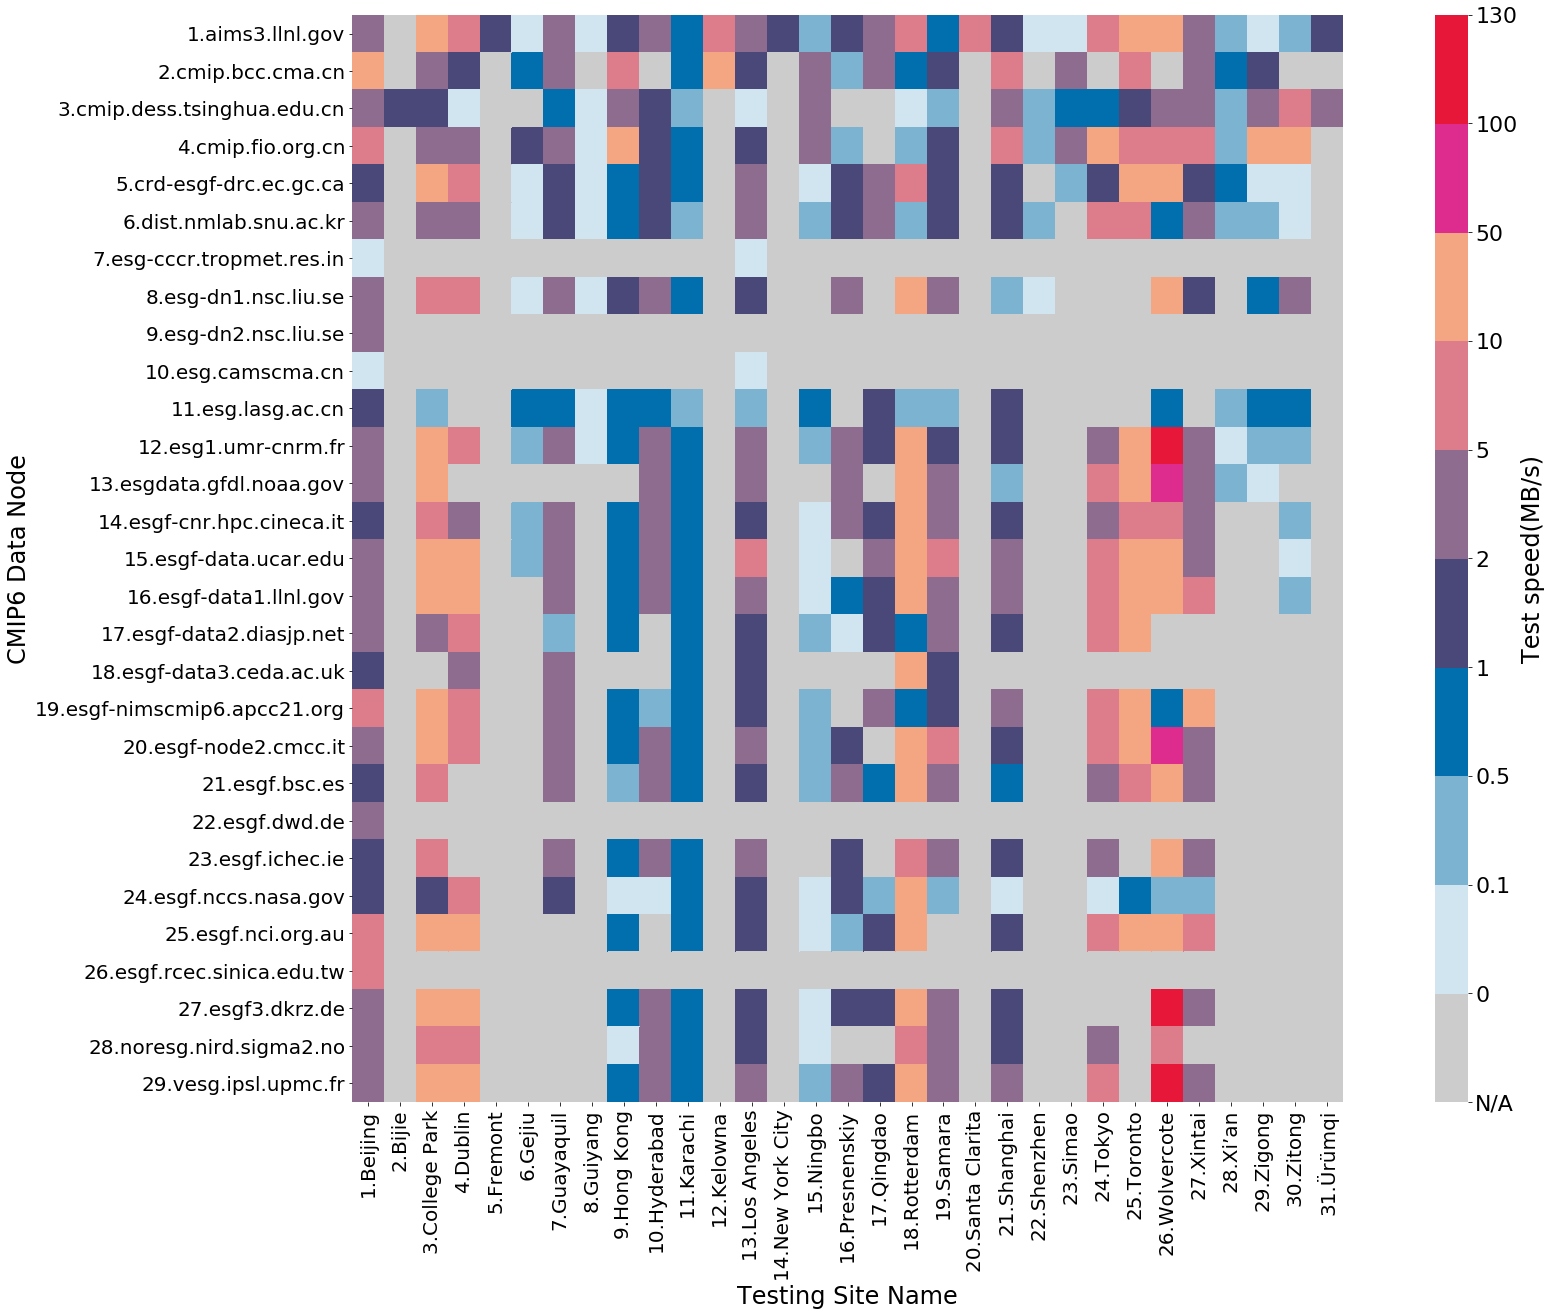

In [20]:
# get city-datanode pair speed mean, and reindex the result to flatten it to simple DataFrame
spd_city_avg=spd_avg[['datanode','city','dl']].groupby(['city','datanode']).mean().reset_index();
# matrix to store the result
city_datanode_speed=pd.DataFrame(-1.0,index=city2datanode['city'].to_numpy(),columns=datanode2city['datanode'].to_numpy())
# function to get speed
def pair_speed(x):
    city_datanode_speed.loc[x['city']][x['datanode']]=x['dl']

spd_city_avg.apply(pair_speed,axis=1)
city_datanode_speed=city_datanode_speed.sort_index()

# Create a Custom color map with difined intervals
custom_color_map = ListedColormap(['#cccccc','#d1e5f0','#7bb3d1', '#016eae', '#4a4779','#8d6c8f','#dd7c8a','#f4a582','#de2c8e','#e61739'])
bounds = [-1, 0, 0.1, 0.5, 1, 2, 5, 10, 50, 100, 130]
custom_norm = matplotlib.colors.BoundaryNorm(bounds, custom_color_map.N)

# Create two appropriately sized subplots
grid_kws = {'width_ratios': (0.9, 0.03), 'wspace': 0.18}
fig, (ax, cbar_ax) = plt.subplots(1, 2, gridspec_kw=grid_kws,figsize=(20,20)) 
# plot heatmap
spd_city_avg_heatmap=sns.heatmap(city_datanode_speed.transpose(),ax=ax, cbar_ax=cbar_ax, cbar_kws={"ticks":[-1, 0, 0.1, 0.5, 1, 2, 5, 10, 50, 100, 130]}, cmap=custom_color_map,norm=custom_norm)
# cbar settings
cbar_ax.set_ylabel('Test speed(MB/s)',size=24)
cbar_ax.set_yticklabels( ['N/A',0, 0.1, 0.5, 1, 2, 5, 10, 50, 100, 130])
cbar_ax.tick_params(labelsize=22,)
# set tick labels
ax.tick_params(labelsize=20)
# set heatmap x tick labels
spd_city_avg_xticklabels=spd_city_avg_heatmap.get_xticklabels()
tickindex=1
for label in spd_city_avg_xticklabels:
    label.set_text(str(tickindex)+'.'+label.get_text())
    tickindex+=1
spd_city_avg_heatmap.set_xticklabels(spd_city_avg_xticklabels)
# set heatmap y tick labels
spd_city_avg_yticklabels=spd_city_avg_heatmap.get_yticklabels()
tickindex=1
for label in spd_city_avg_yticklabels:
    label.set_text(str(tickindex)+'.'+label.get_text())
    tickindex+=1
spd_city_avg_heatmap.set_yticklabels(spd_city_avg_yticklabels)
# set x y labels
spd_city_avg_heatmap.set_ylabel('CMIP6 Data Node',size=24);
spd_city_avg_heatmap.set_xlabel('Testing Site Name',size=24);

### 2.2 Example testing results in Tsinghua

In [21]:
speedtest_tsinghua=pd.read_csv('tsinghua_test_result.csv')
speedtest_tsinghua.sort_values('Destination CMIP6 Data Node')
speedtest_tsinghua.index=np.arange(1, len(speedtest_tsinghua) + 1)

#### Table: Ping, Jitter, Download Speed of all CMIP6 Data Nodes

In [22]:
# to MB/S
speedtest_tsinghua.iloc[:,3]=speedtest_tsinghua.iloc[:,3]/8
speedtest_tsinghua=speedtest_tsinghua.rename(columns={'Download Speed (Mbps)':'Download Speed (MB/s)'})
speedtest_tsinghua

,Destination CMIP6 Data Node,Ping (ms),Jitter (ms),Download Speed (MB/s)
1,aims3.llnl.gov,169.0,6.24,1.95000
2,cmip.bcc.cma.cn,18.2,1.47,45.62500
3,cmip.dess.tsinghua.edu.cn,18.9,24.00,5.88750
4,cmip.fio.org.cn,66.5,1220.00,6.35000
5,crd-esgf-drc.ec.gc.ca,259.0,450.00,0.78625
6,dist.nmlab.snu.ac.kr,264.0,48.70,2.28750
7,esg.camscma.cn,13.7,1.50,0.00000
8,esg.lasg.ac.cn,50.9,23.10,0.76375
9,esg1.umr-cnrm.fr,276.0,543.00,1.22375
10,esg-cccr.tropmet.res.in,298.0,287.00,0.00000


#### Graph: Download Speed of all CMIP6 Data Nodes

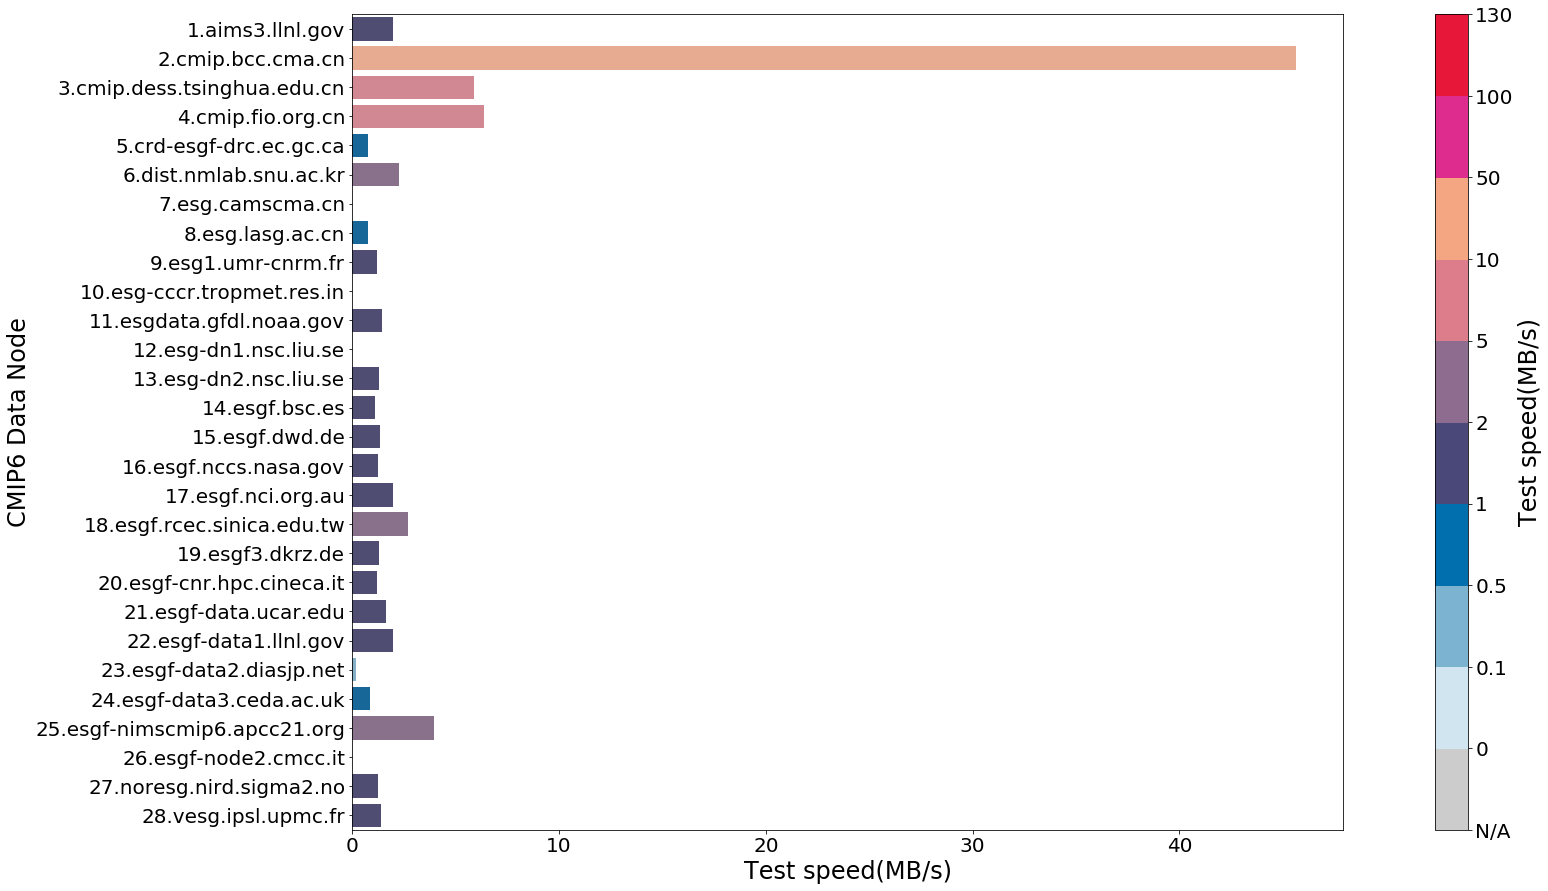

In [23]:
# Create a Custom color map with difined intervals
xdata=speedtest_tsinghua['Download Speed (MB/s)'].to_numpy()
ydata=speedtest_tsinghua['Destination CMIP6 Data Node'].to_numpy()

grid_kws = {'width_ratios': (0.9, 0.03), 'wspace': 0.18}
fig, (ax, cbar_ax) = plt.subplots(1, 2, gridspec_kw=grid_kws,figsize=(20,15))
# plot
speedtest_tsinghua_bar=sns.barplot(x=xdata,y=ydata,orient='h',ax=ax,palette=custom_color_map(custom_norm(xdata)))
# set tick labels
ax.tick_params(labelsize=20)
# set y tick labels
speedtest_tsinghua_yticklabels=speedtest_tsinghua_bar.get_yticklabels()
tickindex=1
for label in speedtest_tsinghua_yticklabels:
    label.set_text(str(tickindex)+'.'+label.get_text())
    tickindex+=1
speedtest_tsinghua_bar.set_yticklabels(speedtest_tsinghua_yticklabels)
# set cbar and labels
matplotlib.colorbar.ColorbarBase(cbar_ax, cmap=custom_color_map,
                                norm=custom_norm,
                                orientation='vertical',ticks=[-1, 0, 0.1, 0.5, 1, 2, 5, 10, 50, 100, 130]);
cbar_ax.set_yticklabels( ['N/A',0, 0.1, 0.5, 1, 2, 5, 10, 50, 100, 130])
cbar_ax.set_ylabel('Test speed(MB/s)', size=24)
cbar_ax.tick_params(labelsize=20)
# set x y labels
speedtest_tsinghua_bar.set_ylabel('CMIP6 Data Node',size=24);
speedtest_tsinghua_bar.set_xlabel('Test speed(MB/s)',size=24);

In [24]:
# city_datanode_speed.sort_index();

In [25]:
### Testing result in countries

In [26]:
# # get country-datanode pair speed mean, and reindex the result to flatten it to simple DataFrame
# spd_country_avg=spd_avg[['datanode','country','dl']].groupby(['country','datanode']).mean().reset_index();
# # matrix to store the result
# country_datanode_speed=pd.DataFrame(-1,index=spd_avg['country'].unique(),columns=spd_avg['datanode'].unique())
# # function to get speed
# def pair_speed(x):
#     if x['dl']==0:
#             country_datanode_speed.loc[x['country']][x['datanode']]=x['dl']
#     else:
#             country_datanode_speed.loc[x['country']][x['datanode']]=np.log(x['dl'])
# #     country_datanode_speed.loc[x['city']][x['datanode']]=x['dl']

# spd_country_avg.apply(pair_speed,axis=1)
# plt.figure(figsize=(12, 10))
# spd_country_avg_heatmap=sns.heatmap(country_datanode_speed.transpose(),vmin=-1,cbar_kws={'label': 'log of test speed(MB/s)'})
# # spd_city_avg_heatmap.set_yscale('symlog')
# spd_country_avg_heatmap.set_xlabel('esting country');
# spd_country_avg_heatmap.set_ylabel('CMIP6 data node');

In [27]:
## overall speed

In [28]:
### city speed violin plot

In [29]:
# spd_avg['dl'].describe();

In [30]:
#### log y scale

In [31]:
# plt.figure(figsize=(30, 8))
# sns.set(style="whitegrid")
# spd_avg_city_violin=sns.violinplot(x="city", y="dl", data=spd_avg,scale='width',cut=0)
# spd_avg_city_violin.set_yscale('symlog')
# spd_avg_city_violin.set_ylabel('log of Download speed in MB/s')
# # spd_avg_violin.set_yticklabels([0,1,10,100,1000])
# spd_avg_city_violin.set_xticklabels(spd_avg_city_violin.get_xticklabels(),rotation=30,fontsize=15);

In [32]:
### Testing results for each testing site

In [33]:
# plt.figure(figsize=(30, 8))
# sns.set(style="whitegrid")
# spd_avg_city_violin=sns.violinplot(x="city", y="dl", data=spd_avg,scale='width',cut=0)
# spd_avg_city_violin.set_ylabel('Download speed (MB/s)',fontsize=20)
# spd_avg_city_violin.set_xticklabels(spd_avg_city_violin.get_xticklabels(),rotation=30,fontsize=15)
# spd_avg_city_violin.set_xlabel('Testing Site Name',fontsize=20);
# # spd_avg_city_violin.set_yscale('symlog')
# # spd_avg_violin.set_yticklabels([0,1,10,100,1000])

In [34]:
### datanode speed violin

In [35]:
#### log y scale

In [36]:
# plt.figure(figsize=(30, 8))
# sns.set(style="whitegrid")
# spd_avg_datanode_violin=sns.violinplot(x="datanode", y="dl", data=spd_avg,scale='width',cut=0)
# spd_avg_datanode_violin.set_yscale('symlog')
# spd_avg_datanode_violin.set_xticklabels(spd_avg_datanode_violin.get_xticklabels(),rotation=30,fontsize=15)
# spd_avg_datanode_violin.set_ylabel('log Download speed in MB/s')
# spd_avg_violin.set_yticklabels([0,1,10,100,1000])

In [37]:
### Testing results for each cmip6 data node

In [38]:
# plt.figure(figsize=(30, 8))
# sns.set(style="whitegrid")
# spd_avg_datanode_violin=sns.violinplot(x="datanode", y="dl", data=spd_avg,scale='width',cut=0)
# # spd_avg_datanode_violin.set_yscale('symlog')
# spd_avg_datanode_violin.set_xticklabels(spd_avg_datanode_violin.get_xticklabels(),fontsize=15,rotation=30)
# # spd_avg_violin.set_yticklabels([0,1,10,100,1000])
# spd_avg_datanode_violin.set_ylabel('Download speed  (MB/s)',fontsize=20);
# spd_avg_datanode_violin.set_xlabel('Testing Node Name',fontsize=20);

In [39]:
### Testing results for each testing country

In [40]:
#### log y scale

In [41]:
# plt.figure(figsize=(30, 8))
# sns.set(style="whitegrid")
# spd_avg_city_violin=sns.violinplot(x="country", y="dl", data=spd_avg,scale='width',cut=0)
# spd_avg_city_violin.set_yscale('symlog')
# spd_avg_violin.set_yticklabels([0,1,10,100,1000])

In [42]:
#### normal y scale

In [43]:
# plt.figure(figsize=(30, 8))
# sns.set(style="whitegrid")
# spd_avg_country_violin=sns.violinplot(x="country", y="dl", data=spd_avg,scale='width',cut=0)
# # spd_avg_city_violin.set_yscale('symlog')
# # spd_avg_violin.set_yticklabels([0,1,10,100,1000])
# spd_avg_country_violin.set_ylabel('Download speed  (MB/s)',fontsize=20);
# spd_avg_country_violin.set_xlabel('Testing Country',fontsize=20);

In [44]:
# city2datanode['country'].value_counts();

In [45]:
# developed_spd_country_avg=spd_country_avg.loc[spd_country_avg['country'].isin(['HK','US','GB','CA','NL','JP'])]
# developed_spd_country_avg.describe();

In [46]:
# developing_spd_country_avg=spd_country_avg.loc[spd_country_avg['country'].isin(['CN','PK','IN','RU'])]
# developing_spd_country_avg.describe();

In [47]:
# spd_country_avg.describe();